# Train and serve a TensorFlow model with TensorFlow Serving

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/serving/).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://www.tensorflow.org/tutorials/keras/basic_classification).

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.1


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [3]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 10s 172us/sample - loss: 0.5269 - acc: 0.8176
Epoch 2/5
60000/60000 [==============================] - 10s 162us/sample - loss: 0.3827 - acc: 0.8656
Epoch 3/5
60000/60000 [==============================] - 9s 145us/sample - loss: 0.3459 - acc: 0.8770
Epoch 4/5
60000/60000 [==============================] - 10s 166us/sample - loss: 0.3249 - acc

## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  TensorFlow Serving allows us to select [which version of a model, or "servable"](../overview) we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [4]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')
!ls -l {export_path}

export_path = /var/tmp/1


Saved model:
total 120
-rw-r--r-- 1 root root 118459 Jun 13 21:57 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun 13 21:57 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://www.tensorflow.org/guide/saved_model#cli_to_inspect_and_execute_savedmodel) in the TensorFlow Guide.

In [5]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax/Softmax:0
  Method name is: tensorflow/serving/predict


# The following does not work within this notebook environment...

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this notebook runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](../docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [22]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!sudo echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
    curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2343  100  2343    0     0  90115      0 --:--:-- --:--:-- --:--:-- 90115
mktemp: failed to create directory via template ‘/tmp/apt-key-gpghome.XXXXXXXXXX’: No such file or directory
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Err:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease    
  Couldn't create temporary file /tmp/apt.conf.uNx521 for passing config to apt-key
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Err:3 http://archive.ubuntu.com/ubuntu bionic InRelease                        
  Couldn't create temporary file /tmp/apt.conf.L9XIV7 for passing config to apt-key
Get:2 http://security.ubuntu.com/ubunt

### Install TensorFlow Serving

This is all you need - one command line!

In [17]:
!apt-get install tensorflow-model-server

Reading package lists... Error!
E: Couldn't create temporary file to work with /var/lib/apt/lists/archive.ubuntu.com_ubuntu_dists_bionic_InRelease - mkstemp (2: No such file or directory)
E: The package lists or status file could not be parsed or opened.


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [18]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [19]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 2 in a separate thread.


In [20]:
!tail server.log

nohup: failed to run command 'tensorflow_model_server': No such file or directory


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

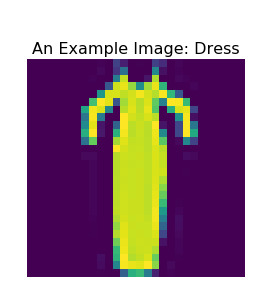

In [11]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [12]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0] ... 0.0], [0.0]]]], "signature_name": "serving_default"}


### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [14]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[np.argmax(predictions[0])], test_labels[0]))

You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/fashion_model:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5e62148890>: Failed to establish a new connection: [Errno 111] Connection refused',))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

In [15]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], test_labels[i], class_names[np.argmax(predictions[i])], test_labels[i]))

ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/fashion_model/versions/1:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5e621486d0>: Failed to establish a new connection: [Errno 111] Connection refused',))